In [1]:
from scipy import special as sp
import numpy as np
import matplotlib.pyplot as plt

from ipynb.fs.full.mie_functions import *

In [2]:
# Import wavelength and refractive index values
ref_lam_silver, ref_n_silver, ref_k_silver = import_data("McPeak_silver.csv")
m_silver = ref_n_silver + 1j * ref_k_silver # SIGN!!!!!!!!
ref_lam_gold, ref_n_gold, ref_k_gold = import_data("McPeak_gold.csv")
m_gold = ref_n_gold + 1j * ref_k_gold # SIGN!!!!!!!!

In [3]:
# Define radii and respective coordinate arrays for plotting
r1 = 0.01 #micrometers
r2 = 0.04 #micrometers

x_arr1 = np.linspace(1.0, 2.0, 100) * r1 * 1e3  #nm
x_arr2 = np.linspace(1.0, 2.0, 100) * r2 * 1e3  #nm

y_arr = np.array([0.0]) #nm

r_arr1 = np.sqrt(x_arr1**2 + np.ones_like(x_arr1)*y_arr[0]**2) #nm
r_arr2 = np.sqrt(x_arr2**2 + np.ones_like(x_arr2)*y_arr[0]**2) #nm

### Finding the resonant wavelength of nanoparticles of two different diameters

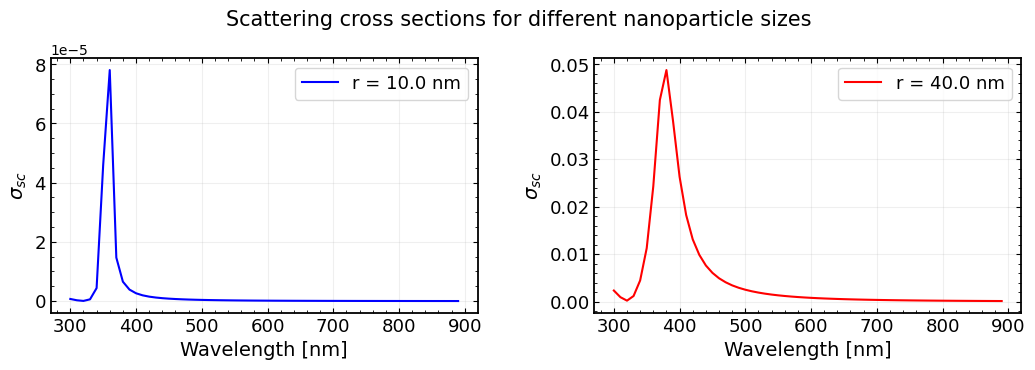

Resonant wavelength for r = 10.0 nm: 360.0 nm
Resonant wavelength for r = 40.0 nm: 380.0 nm


In [4]:
A_r1, B_r1 = a_1_b_1_lists(ref_ind = m_silver, lam_list = ref_lam_silver, r = r1, YSK = True)
A_r2, B_r2 = a_1_b_1_lists(ref_ind = m_silver, lam_list = ref_lam_silver, r = r2, YSK = True)

sca_cross_section_r1 = sca_cross_section_analytical(A_r1, B_r1, ref_lam_silver) # electric + magnetic dipole
sca_cross_section_r2 = sca_cross_section_analytical(A_r2, B_r2, ref_lam_silver) # only electric dipole

general_plot_style([ref_lam_silver[:60]*1e3, ref_lam_silver[:60]*1e3], [sca_cross_section_r1[:60], \
                   sca_cross_section_r2[:60]], legendlabels = [f'r = {r1*1e3} nm', f'r = {r2*1e3} nm'], \
                   colors = ['blue', 'red'], ls = ['solid', 'solid'], figsize = [11,4], ylims = None, \
                   subplots = [1,2], xlabel = 'Wavelength [nm]', ylabel = '$\sigma_{sc}$', \
                   title = 'Scattering cross sections for different nanoparticle sizes', \
                   filename = 'scat_cross_sections.jpg', savefig = True)

lam1 = ref_lam_silver[np.where(sca_cross_section_r1 == np.max(sca_cross_section_r1))][0]
lam2 = ref_lam_silver[np.where(sca_cross_section_r2 == np.max(sca_cross_section_r2))][0]
print(f'Resonant wavelength for r = {r1*1e3} nm: {lam1*1e3} nm')
print(f'Resonant wavelength for r = {r2*1e3} nm: {lam2*1e3} nm')

### Maximum field enhancement for nanoparticles of two different diameters

(incident field at resonant wavelength)

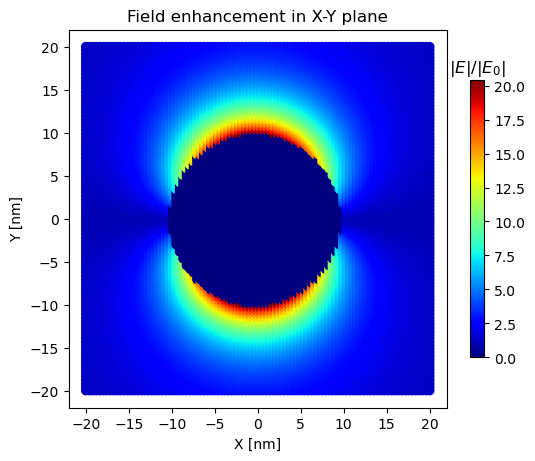

('At incoming wavelength of 360.0 nm',
 'Maximum scattered field = 20.422256542018516 E_0')

<Figure size 640x480 with 0 Axes>

In [5]:
# r = 10 nm, resonant wavelength = 360 nm
x_vals = np.linspace(-20.0,20.0,100) #nm
y_vals = np.linspace(-20.0,20.0,100) #nm

plot_scattered_field(x_vals, y_vals, 1e-15, m_silver, lam_list = ref_lam_silver, lam_value = 0.36, r = r1, \
                     filename = 'enhancement_r_10.txt', n = 1, figsize = [6.1,6])

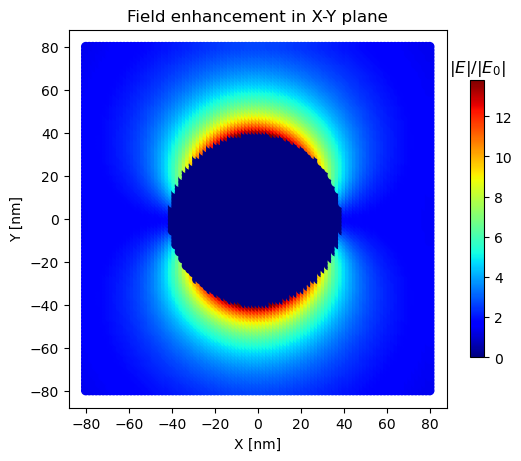

('At incoming wavelength of 380.0 nm',
 'Maximum scattered field = 13.802935960956038 E_0')

<Figure size 640x480 with 0 Axes>

In [6]:
# r = 40 nm, resonant wavelength = 380 nm
x_vals = np.linspace(-80.0,80.0,100) #nm
y_vals = np.linspace(-80.0,80.0,100) #nm

plot_scattered_field(x_vals, y_vals, 1e-15, m_silver, lam_list = ref_lam_silver, lam_value = 0.38, r = r2, \
                     filename = 'enhancement_r_40.txt', n = 1, figsize = [6.1,6])

### Rabi frequency and decay rates of the TLS 
(as a function of distance from the surface of the nanosphere)

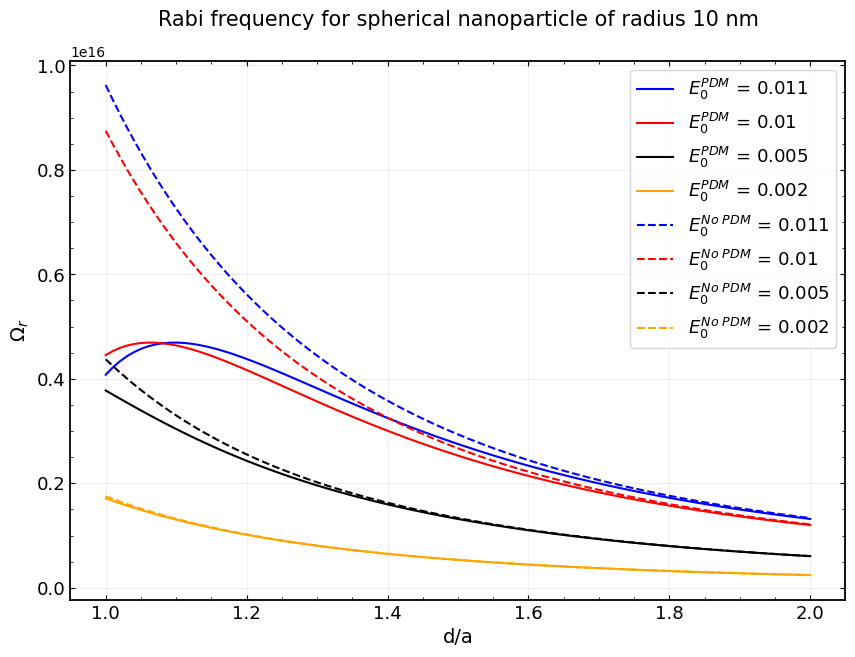

In [7]:
E0s1 = [0.011, 0.010, 0.005, 0.002]
J_factor01, E01, omega_np01, omega01 = rabi_frequency(x_points = x_arr1, y = y_arr[0], z = 1e-15, refr_ind = m_silver, \
                                            lam_list = ref_lam_silver, r = r1, n = 1, lam_value = lam1, E_0 = E0s1[0],\
                                            print_vals = False)
J_factor11, E11, omega_np11, omega11 = rabi_frequency(x_points = x_arr1, y = y_arr[0], z = 1e-15, refr_ind = m_silver, \
                                            lam_list = ref_lam_silver, r = r1, n = 1, lam_value = lam1, \
                                            E_0 = E0s1[1], print_vals = False)
J_factor21, E21, omega_np21, omega21 = rabi_frequency(x_points = x_arr1, y = y_arr[0], z = 1e-15, refr_ind = m_silver, \
                                            lam_list = ref_lam_silver, r = r1, n = 1, lam_value = lam1, \
                                            E_0 = E0s1[2], print_vals = False)
J_factor31, E31, omega_np31, omega31 = rabi_frequency(x_points = x_arr1, y = y_arr[0], z = 1e-15, refr_ind = m_silver, \
                                            lam_list = ref_lam_silver, r = r1, n = 1, lam_value = lam1, \
                                            E_0 = E0s1[3], print_vals = False)
st1 = '$E_0^{PDM}$'
st2 = '$E_0^{No \,\, PDM}$'

general_plot_style([r_arr1/(r1*1e3), r_arr1/(r1*1e3), r_arr1/(r1*1e3), r_arr1/(r1*1e3), r_arr1/(r1*1e3), \
                    r_arr1/(r1*1e3), r_arr1/(r1*1e3), r_arr1/(r1*1e3)], [omega01, omega11, omega21, omega31,\
                    omega_np01, omega_np11, omega_np21, omega_np31], legendlabels = [f'{st1} = {E0s1[0]}', \
                    f'{st1} = {E0s1[1]}', f'{st1} = {E0s1[2]}', f'{st1} = {E0s1[3]}', f'{st2} = {E0s1[0]}', \
                    f'{st2} = {E0s1[1]}', f'{st2} = {E0s1[2]}', f'{st2} = {E0s1[3]}'], \
                    colors = ['blue', 'red', 'black', 'orange', 'blue', 'red', 'black', 'orange'], \
                    ls = ['solid', 'solid', 'solid', 'solid', '--', '--', '--', '--'], figsize = [10,7], \
                    ylims = None, subplots = [1,1], xlabel = 'd/a', ylabel = '$\Omega_r$', \
                    title = f'Rabi frequency for spherical nanoparticle of radius {r1*1e3:.0f} nm', \
                    filename = f'rabi_frequency_wrt_field_r_{r1}.jpg', savefig = True)

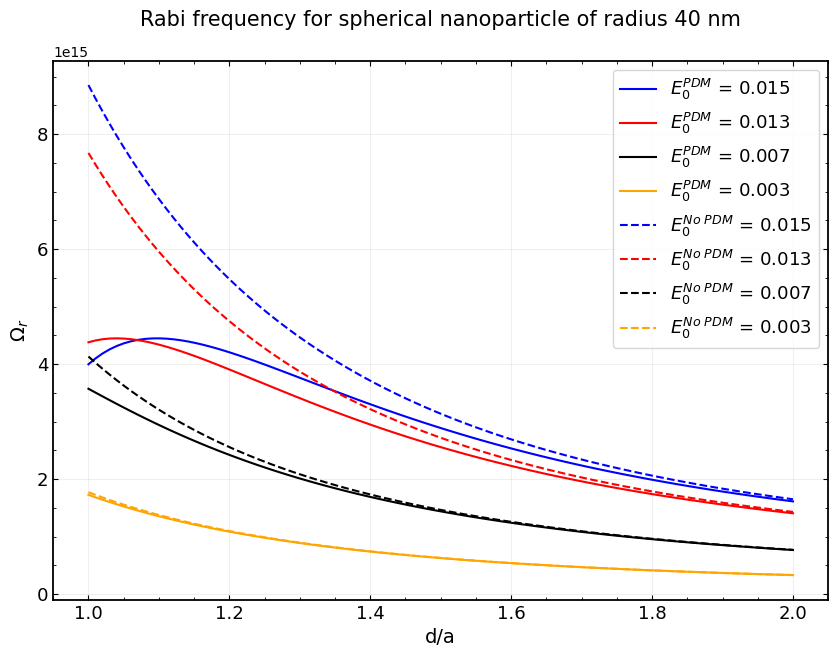

In [8]:
E0s2 = [0.015, 0.013, 0.007, 0.003]
J_factor02, E02, omega_np02, omega02 = rabi_frequency(x_points = x_arr2, y = y_arr[0], z = 1e-15, refr_ind = m_silver, \
                                            lam_list = ref_lam_silver, r = r2, n = 1, lam_value = lam2, E_0 = E0s2[0],\
                                            print_vals = False)
J_factor12, E12, omega_np12, omega12 = rabi_frequency(x_points = x_arr2, y = y_arr[0], z = 1e-15, refr_ind = m_silver, \
                                            lam_list = ref_lam_silver, r = r2, n = 1, lam_value = lam2, \
                                            E_0 = E0s2[1], print_vals = False)
J_factor22, E22, omega_np22, omega22 = rabi_frequency(x_points = x_arr2, y = y_arr[0], z = 1e-15, refr_ind = m_silver, \
                                            lam_list = ref_lam_silver, r = r2, n = 1, lam_value = lam2, \
                                            E_0 = E0s2[2], print_vals = False)
J_factor32, E32, omega_np32, omega32 = rabi_frequency(x_points = x_arr2, y = y_arr[0], z = 1e-15, refr_ind = m_silver, \
                                            lam_list = ref_lam_silver, r = r2, n = 1, lam_value = lam2, \
                                            E_0 = E0s2[3], print_vals = False)

general_plot_style([r_arr2/(r2*1e3), r_arr2/(r2*1e3), r_arr2/(r2*1e3), r_arr2/(r2*1e3), r_arr2/(r2*1e3), \
                    r_arr2/(r2*1e3), r_arr2/(r2*1e3), r_arr2/(r2*1e3)], [omega02, omega12, omega22, omega32, \
                    omega_np02, omega_np12, omega_np22, omega_np32], legendlabels = [f'{st1} = {E0s2[0]}', \
                    f'{st1} = {E0s2[1]}', f'{st1} = {E0s2[2]}', f'{st1} = {E0s2[3]}', f'{st2} = {E0s2[0]}', \
                    f'{st2} = {E0s2[1]}', f'{st2} = {E0s2[2]}', f'{st2} = {E0s2[3]}'], \
                    colors = ['blue', 'red', 'black', 'orange', 'blue', 'red', 'black', 'orange'], \
                    ls = ['solid', 'solid', 'solid', 'solid', '--', '--', '--', '--'], figsize = [10,7], \
                    ylims = None, subplots = [1,1], xlabel = 'd/a', ylabel = '$\Omega_r$', \
                    title = f'Rabi frequency for spherical nanoparticle of radius {r2*1e3:.0f} nm', \
                    filename = f'rabi_frequency_wrt_field_r_{r2}.jpg', savefig = True)

In [132]:
d_ii1 = [0.0, 10, 50, 90, 100]
E_0_fixed = 0.0001
# r = 10 nm
J_factor03, E03, omega_np03, omega03 = rabi_frequency(x_points = x_arr1, y = y_arr[0], z = 1e-15, dperm = d_ii1[1], \
                                                      refr_ind = m_silver, lam_list = ref_lam_silver, r = r1, \
                                                      n = 1, lam_value = lam1, E_0 = E_0_fixed, print_vals = False)
J_factor13, E13, omega_np13, omega13 = rabi_frequency(x_points = x_arr1, y = y_arr[0], z = 1e-15, dperm = d_ii1[2], \
                                                      refr_ind = m_silver, lam_list = ref_lam_silver, r = r1, \
                                                      n = 1, lam_value = lam1, E_0 = E_0_fixed, print_vals = False)
J_factor23, E23, omega_np23, omega23 = rabi_frequency(x_points = x_arr1, y = y_arr[0], z = 1e-15, dperm = d_ii1[3], \
                                                      refr_ind = m_silver, lam_list = ref_lam_silver, r = r1, \
                                                      n = 1, lam_value = lam1, E_0 = E_0_fixed, print_vals = False)
J_factor33, E33, omega_np33, omega33 = rabi_frequency(x_points = x_arr1, y = y_arr[0], z = 1e-15, dperm = d_ii1[4], \
                                                      refr_ind = m_silver, lam_list = ref_lam_silver, r = r1, \
                                                      n = 1, lam_value = lam1, E_0 = E_0_fixed, print_vals = False)
# r = 40 nm
d_ii_2 = [0.0, 10, 50, 150, 200]
J_factor04, E04, omega_np04, omega04 = rabi_frequency(x_points = x_arr2, y = y_arr[0], z = 1e-15, dperm = d_ii_2[1], \
                                                      refr_ind = m_silver, lam_list = ref_lam_silver, r = r2, \
                                                      n = 1, lam_value = lam2, E_0 = E_0_fixed, print_vals = False)
J_factor14, E14, omega_np14, omega14 = rabi_frequency(x_points = x_arr2, y = y_arr[0], z = 1e-15, dperm = d_ii_2[2], \
                                                      refr_ind = m_silver, lam_list = ref_lam_silver, r = r2, \
                                                      n = 1, lam_value = lam2, E_0 = E_0_fixed, print_vals = False)
J_factor24, E24, omega_np24, omega24 = rabi_frequency(x_points = x_arr2, y = y_arr[0], z = 1e-15, dperm = d_ii_2[3], \
                                                      refr_ind = m_silver, lam_list = ref_lam_silver, r = r2, \
                                                      n = 1, lam_value = lam2, E_0 = E_0_fixed, print_vals = False)
J_factor34, E34, omega_np34, omega34 = rabi_frequency(x_points = x_arr2, y = y_arr[0], z = 1e-15, dperm = d_ii_2[4], \
                                                      refr_ind = m_silver, lam_list = ref_lam_silver, r = r2, \
                                                      n = 1, lam_value = lam2, E_0 = E_0_fixed, print_vals = False)

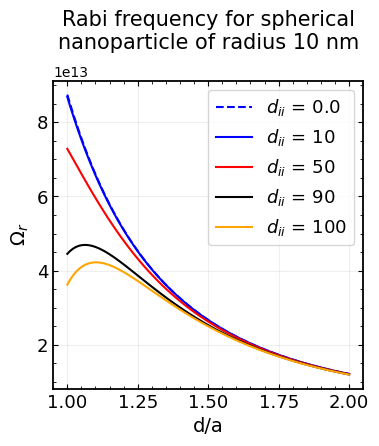

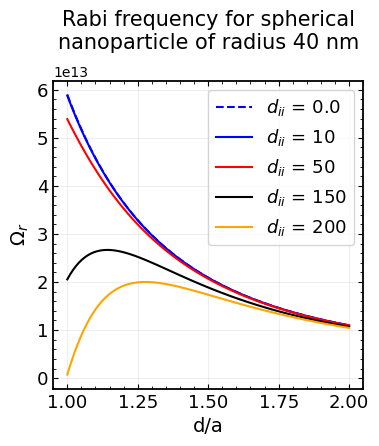

In [133]:
st = '$d_{ii}$'
general_plot_style([r_arr1/(r1*1e3), r_arr1/(r1*1e3), r_arr1/(r1*1e3), r_arr1/(r1*1e3), r_arr1/(r1*1e3)], \
                   [omega_np03, omega03, omega13, omega23, omega33], \
                   legendlabels = [f'{st} = {d_ii1[0]}', f'{st} = {d_ii1[1]}', f'{st} = {d_ii1[2]}', \
                   f'{st} = {d_ii1[3]}', f'{st} = {d_ii1[4]}'],
                   colors = ['blue', 'blue', 'red', 'black', 'orange'], \
                   ls = ['--', 'solid', 'solid', 'solid', 'solid'], figsize = [4,4], \
                   ylims = None, subplots = [1,1], xlabel = 'd/a', ylabel = '$\Omega_r$', \
                   title = f'Rabi frequency for spherical nanoparticle of radius {r1*1e3:.0f} nm', \
                   filename = f'rabi_frequency_wrt_dperm_r_{r1}.jpg', savefig = True)

general_plot_style([r_arr2/(r2*1e3), r_arr2/(r2*1e3), r_arr2/(r2*1e3), r_arr2/(r2*1e3), r_arr2/(r2*1e3)], \
                   [omega_np04, omega04, omega14, omega24, omega34], \
                   legendlabels = [f'{st} = {d_ii_2[0]}', f'{st} = {d_ii_2[1]}', f'{st} = {d_ii_2[2]}', \
                   f'{st} = {d_ii_2[3]}', f'{st} = {d_ii_2[4]}'],
                   colors = ['blue', 'blue', 'red', 'black', 'orange'], \
                   ls = ['--', 'solid', 'solid', 'solid', 'solid'], figsize = [4,4], \
                   ylims = None, subplots = [1,1], xlabel = 'd/a', ylabel = '$\Omega_r$', \
                   title = f'Rabi frequency for spherical nanoparticle of radius {r2*1e3:.0f} nm', \
                   filename = f'rabi_frequency_wrt_dperm_r_{r2}.jpg', savefig = True)

In [11]:
J_factor, E, omega_np, omega = rabi_frequency(x_points = x_arr1, y = y_arr[0], z = 1e-15, refr_ind = m_silver, \
                                           lam_list = ref_lam_silver, r = r1, n = 1, lam_value = lam1, E_0 = 0.01, \
                                           print_vals = False)

[10.60606061]
4.693762743056292


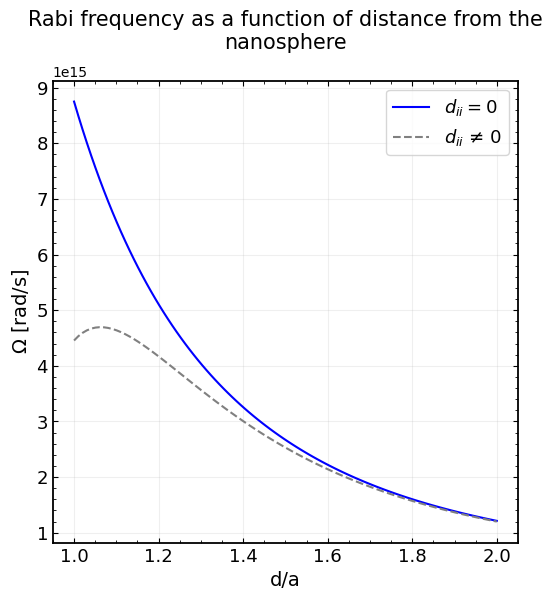

In [82]:
general_plot_style(x = [r_arr1/(r1*1e3), r_arr1/(r1*1e3)], y = [omega_np, omega], legendlabels = ['$d_{ii} = 0$', \
                   u'$d_{ii}$ \u2260 $0$'], colors = ['blue', 'grey'], ls = ['solid', '--'], ylims = None, \
                   xlabel = 'd/a', ylabel = '$\Omega$ [rad/s]', \
                   title = 'Rabi frequency as a function of distance from the nanosphere', figsize = [6,6])

print(r_arr1[np.where(omega == np.max(omega))])
print(np.max(omega)*1e-15)

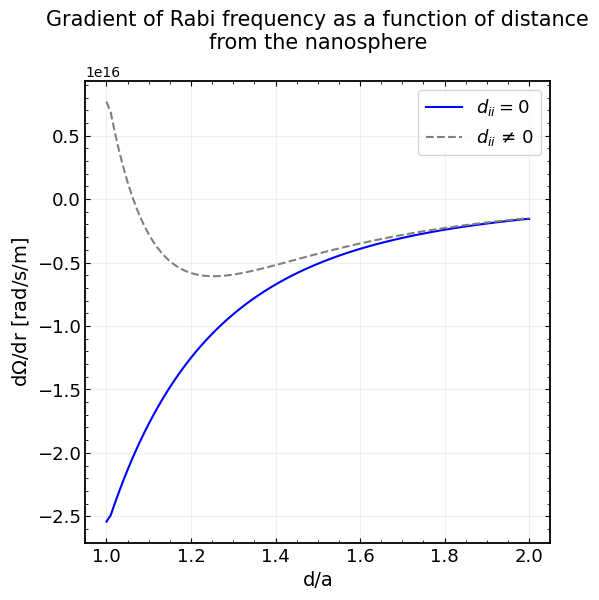

In [13]:
general_plot_style(x = [r_arr1/(r1*1e3), r_arr1/(r1*1e3)], y = [np.gradient(omega_np, r_arr1/(r1*1e3)), \
                   np.gradient(omega, r_arr1/(r1*1e3))], legendlabels = ['$d_{ii} = 0$', u'$d_{ii}$ \u2260 $0$'], \
                   colors = ['blue', 'grey'], ls = ['solid', '--'], ylims = None, xlabel = 'd/a', \
                   ylabel = 'd$\Omega$/dr [rad/s/m]', figsize = [6,6], \
                   title = 'Gradient of Rabi frequency as a function of distance from the nanosphere', \
                   filename = 'rabi_frequency.jpg', savefig = True)

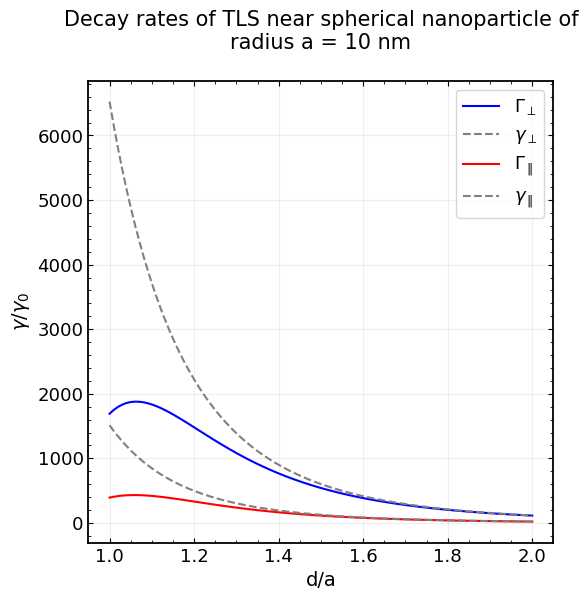

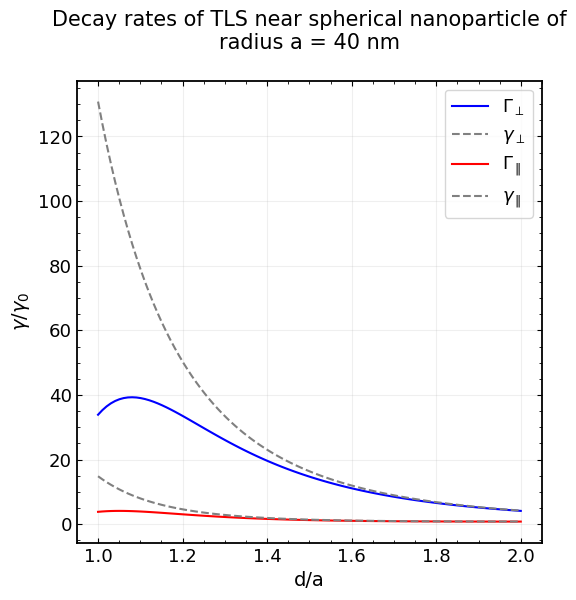

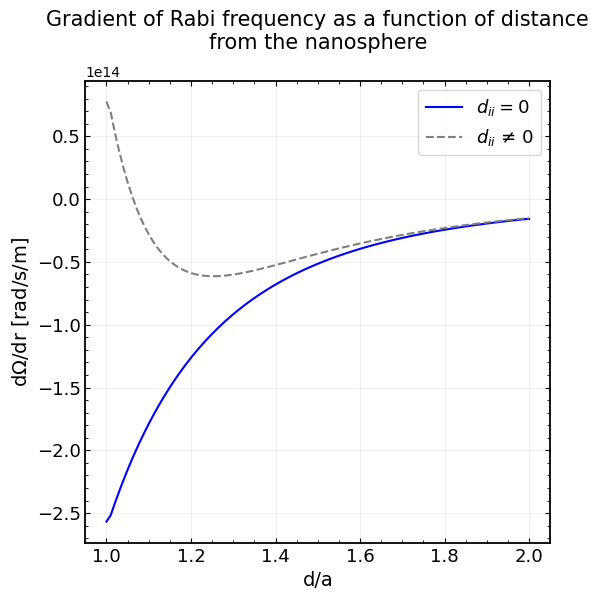

In [14]:
# Decay rates
index1 = np.where(ref_lam_silver == lam1)
mval1 = m_silver[index1][0]
index2 = np.where(ref_lam_silver == lam2)
mval2 = m_silver[index2][0]

A_list, B_list, gamma_norm, gamma_tang, gamma_norm_rad, gamm_tang_rad = gamma_factors(r_arr1*1e-9, mval1, lam1*1e-6, \
                                                                                      r1*1e-6, n = 1, order = 1, \
                                                                                      plot = False)
general_plot_style(x = [r_arr1/(r1*1e3),r_arr1/(r1*1e3),r_arr1/(r1*1e3),r_arr1/(r1*1e3)], \
                   y = [(J_factor**2)*gamma_norm, gamma_norm, (J_factor**2)*gamma_tang, gamma_tang], figsize = [6,6],\
                   legendlabels = ['$\Gamma_{\perp}$', '$\gamma_{\perp}$', '$\Gamma_{\, \|}$', '$\gamma_{\, \|}$'], \
                   colors = [ 'blue', 'grey', 'red', 'grey'], xlabel = 'd/a', ylabel = '$\gamma / \gamma_0$', \
                   ls = ['solid', '--', 'solid', '--'], \
                   title = f'Decay rates of TLS near spherical nanoparticle of radius a = {r1*1e3:.0f} nm', \
                   filename = 'decay_rates.jpg', savefig = True)

A_list, B_list, gamma_norm, gamma_tang, gamma_norm_rad, gamm_tang_rad = gamma_factors(r_arr2*1e-9, mval2, lam2*1e-6, \
                                                                                      r2*1e-6, n = 1, order = 1, \
                                                                                      plot = False)
general_plot_style(x = [r_arr2/(r2*1e3),r_arr2/(r2*1e3),r_arr2/(r2*1e3),r_arr2/(r2*1e3)], \
                   y = [(J_factor**2)*gamma_norm, gamma_norm, (J_factor**2)*gamma_tang, gamma_tang], figsize = [6,6],\
                   legendlabels = ['$\Gamma_{\perp}$', '$\gamma_{\perp}$', '$\Gamma_{\, \|}$', '$\gamma_{\, \|}$'], \
                   colors = [ 'blue', 'grey', 'red', 'grey'], xlabel = 'd/a', ylabel = '$\gamma / \gamma_0$', \
                   ls = ['solid', '--', 'solid', '--'], \
                   title = f'Decay rates of TLS near spherical nanoparticle of radius a = {r2*1e3:.0f} nm', \
                   filename = 'decay_rates.jpg', savefig = True)
general_plot_style(x = [r_arr2/(r2*1e3), r_arr2/(r2*1e3)], y = [np.gradient(omega_np), np.gradient(omega)], \
                   legendlabels = ['$d_{ii} = 0$', u'$d_{ii}$ \u2260 $0$'], colors = ['blue', 'grey'], \
                   ls = ['solid', '--'], ylims = None, xlabel = 'd/a', ylabel = 'd$\Omega$/dr [rad/s/m]', \
                   title = 'Gradient of Rabi frequency as a function of distance from the nanosphere',figsize = [6,6], \
                   filename = 'rabi_frequency.jpg', savefig = True)

### Change of the Rabi frequency of the TLS as a function of distance and incident field

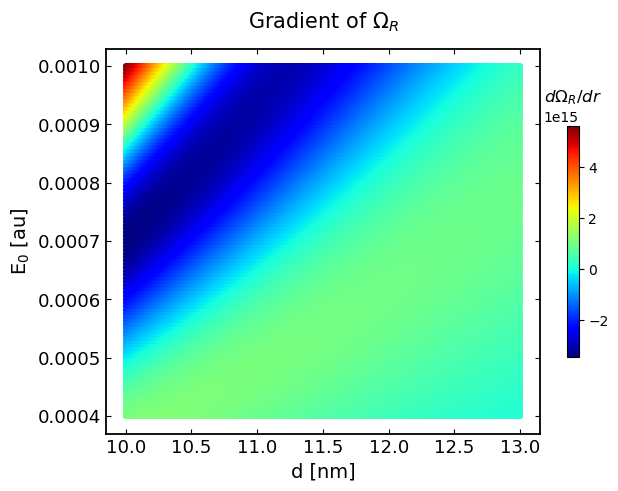

In [78]:
def rabi_colorbar(x_points, y, z, refr_ind, lam_list, r, dperm = 1, E0s = np.linspace(0.0004, 0.001, 100), \
                  n = 1, lam_value = 0.36, print_vals = False, correction = True):

    y_vals = np.ones_like(x_points)*y
    r_arr = np.sqrt(x_points**2 + y_vals**2)
    Evals = np.zeros((len(x_points), len(E0s)), dtype = 'float')
    rs = np.zeros((len(x_points), len(E0s)), dtype = 'float')
    colors = np.zeros((len(x_points), len(E0s)), dtype = 'float')

    ind = 0
    for j in E0s:
        J_factor, E, omega_np, omega = rabi_frequency(x_points = x_points, y = y, z = z, E_0 = j, dperm = dperm, \
                                                      refr_ind = refr_ind, lam_list = lam_list, r = r, n = n, \
                                                      lam_value = lam_value, print_vals = False)
        Evals[:,ind] = E / (5.14220675112*1e11)
        rs[:,ind] = r_arr
        if correction:
            colors[:,ind] = np.gradient(omega_np, r_arr/(r*1e3))
        else:
            colors[:,ind] = np.gradient(omega, r_arr/(r*1e3))
        if len(r_arr[np.where(np.abs(colors[:,ind]) <= 1)] != 0):
            print(Evals[:,ind][0], r_arr[np.where(np.abs(colors[:,ind]) <= 1)])

        ind += 1
        
    fig, ax = plt.subplots(1,1, figsize = (7, 5))
    plt.scatter(rs, Evals, c=colors, cmap='jet', label = 'full', marker = '.')
    ax.set_ylabel('E$_0$ [au]', fontsize=14)
    ax.set_xlabel('d [nm]', fontsize=14)
    ax.tick_params(axis="both", direction="in", which="both", right=True, top=True, labelsize=13)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.3)
    cbar = plt.colorbar(shrink = 0.6) #, ticks = [0.0,3e16,6e16])
    cbar.ax.set_title(r'$d\Omega_R / dr$')
    ax.set_title('Gradient of $\Omega_R$', fontsize = 15, pad = 15)
    
x_arr = np.linspace(1.0, 1.3, 1000) * r1 * 1e3  #nm
rabi_colorbar(x_points = x_arr, y = y_arr[0], z = 1e-15, dperm = 50.0, refr_ind = m_silver, \
              lam_list = ref_lam_silver, \
              r = r1, n = 1, lam_value = 0.36, print_vals = False, correction = False)

### Evolution of the TLS

#### Original Hamiltonian

In [ ]:
qutip_integration(m_silver, ref_lam_silver, d_tr = 1, d_ee = 0.0, x_points = np.array([30.4*(10**-9), 30.6*(10**-9)]), E_0 = 0.0001, \
                  tf = 10000e-15, transformed_H = False)

In [ ]:
qutip_integration(m_silver, ref_lam_silver, x_points = np.array([30.4*(10**-9)]), E_0 = 0.01, tf = 10e-15)

#### Transformed Hamiltonian

Omega 69667.69637206153 Delta 231.90989319200003 4134.137336055725
Omega 67796.145460274 Delta 219.616828411 4134.137336055725


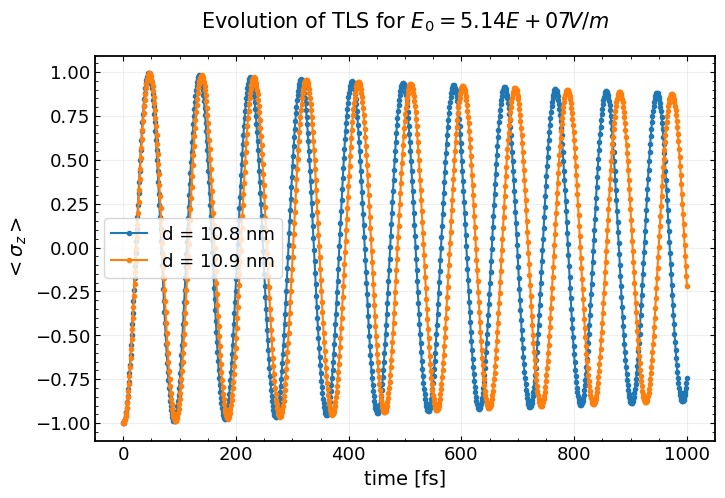

In [45]:
qutip_integration(m_silver, ref_lam_silver, x_points = np.array([10.8*1e-9, 10.9*1e-9]), d_perm = 0.0, \
                  E_0 = 0.0006, r = 0.01, lam_val = 0.36, tf = 1e-12, transformed_H = True)

Omega 67499.29326054631 Delta 217.69775094500002 4134.137336055725
Omega 69163.30110353406 Delta 228.563877343 4134.137336055725


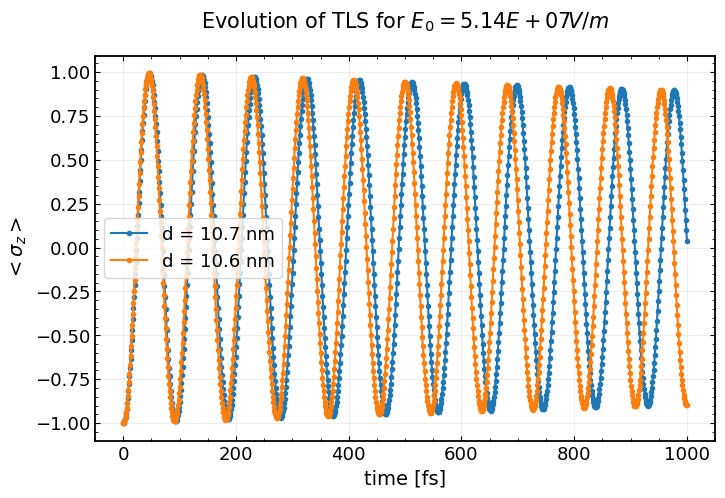

In [87]:
qutip_integration(m_silver, ref_lam_silver, x_points = np.array([10.7*1e-9, 10.6*1e-9]), d_perm = 50.0, \
                  E_0 = 0.0001, r = 0.01, lam_val = 0.36, tf = 1e-12, transformed_H = True)

Omega -17003.974910207784 Delta 14.582262208000001 4134.137336055725
Omega -16875.8028415263 Delta 14.363254762 4134.137336055725


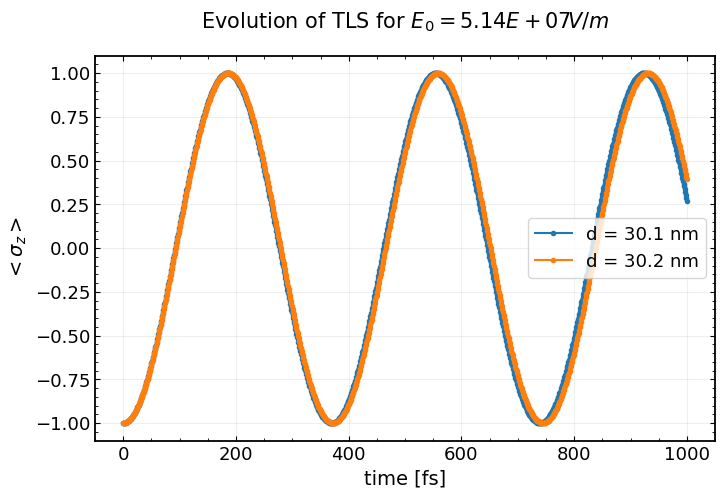

In [135]:
qutip_integration(m_silver, ref_lam_silver, x_points = np.array([30.1*1e-9, 30.2*1e-9]), d_perm = 200.0, \
                  E_0 = 0.0001, r = 0.04, lam_val = 0.38, tf = 1e-12, transformed_H = True)